## Project : Cardiovascular Risk Prediction Classification

### 1. Topic 
- Predict whether a patient has a 10-year risk of future coronary heart disease (CHD)

### 2. Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

### 3. Load Dataset

In [9]:
df = pd.read_csv('data_cardiovascular_risk.csv')
df

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,3385,60,1.0,F,NO,0.0,0.0,0,0,0,261.0,123.5,79.0,29.28,70.0,103.0,0
3386,3386,46,1.0,F,NO,0.0,0.0,0,0,0,199.0,102.0,56.0,21.96,80.0,84.0,0
3387,3387,44,3.0,M,YES,3.0,0.0,0,1,0,352.0,164.0,119.0,28.92,73.0,72.0,1
3388,3388,60,1.0,M,NO,0.0,NaN,0,1,0,191.0,167.0,105.0,23.01,80.0,85.0,0


### 4. Data Cleaning

In [10]:
# Handle missing values
# Drop 'id' column if present
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# Convert categorical columns
df['sex'] = df['sex'].map({'F': 0, 'M': 1})
df['is_smoking'] = df['is_smoking'].map({'NO': 0, 'YES': 1})

# Remove duplicates
df = df.drop_duplicates()

# Check missing values
missing = df.isnull().sum()
# Impute numerical columns with median, categorical with mode
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = ['sex', 'is_smoking']

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

### 5. Exploratory Data Analysis

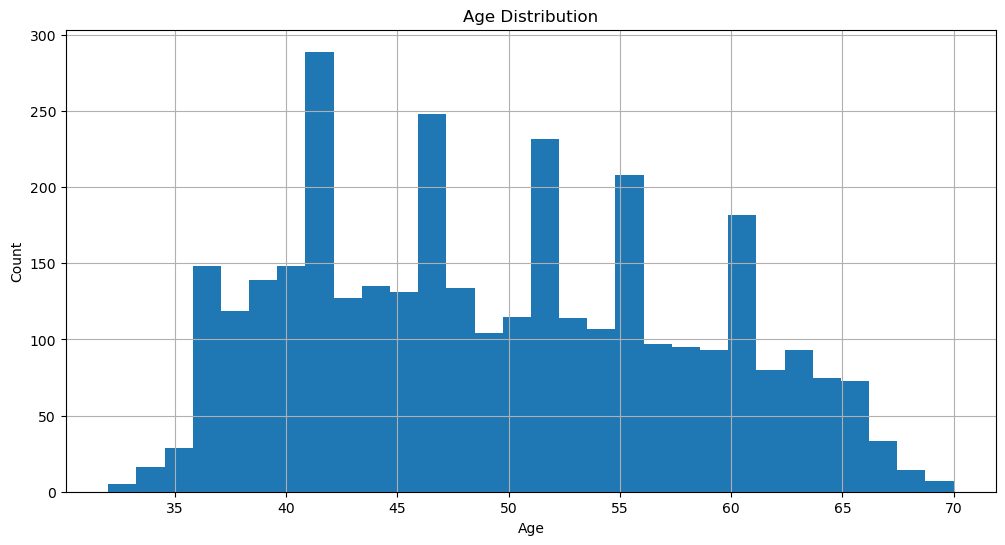

In [11]:
# Univariate analysis
plt.figure(figsize=(12,6))
df['age'].hist(bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

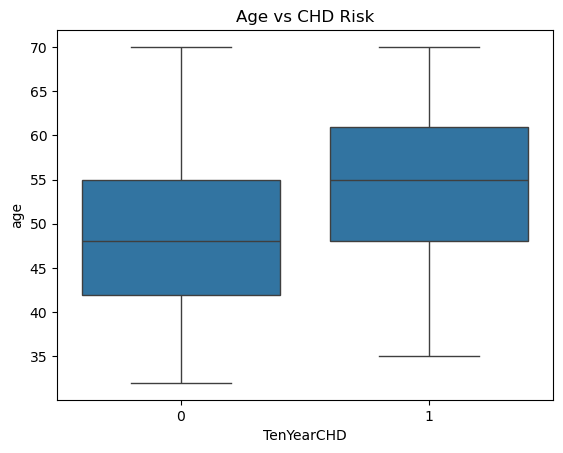

In [12]:
# Bivariate analysis
sns.boxplot(x='TenYearCHD', y='age', data=df)
plt.title('Age vs CHD Risk')
plt.show()

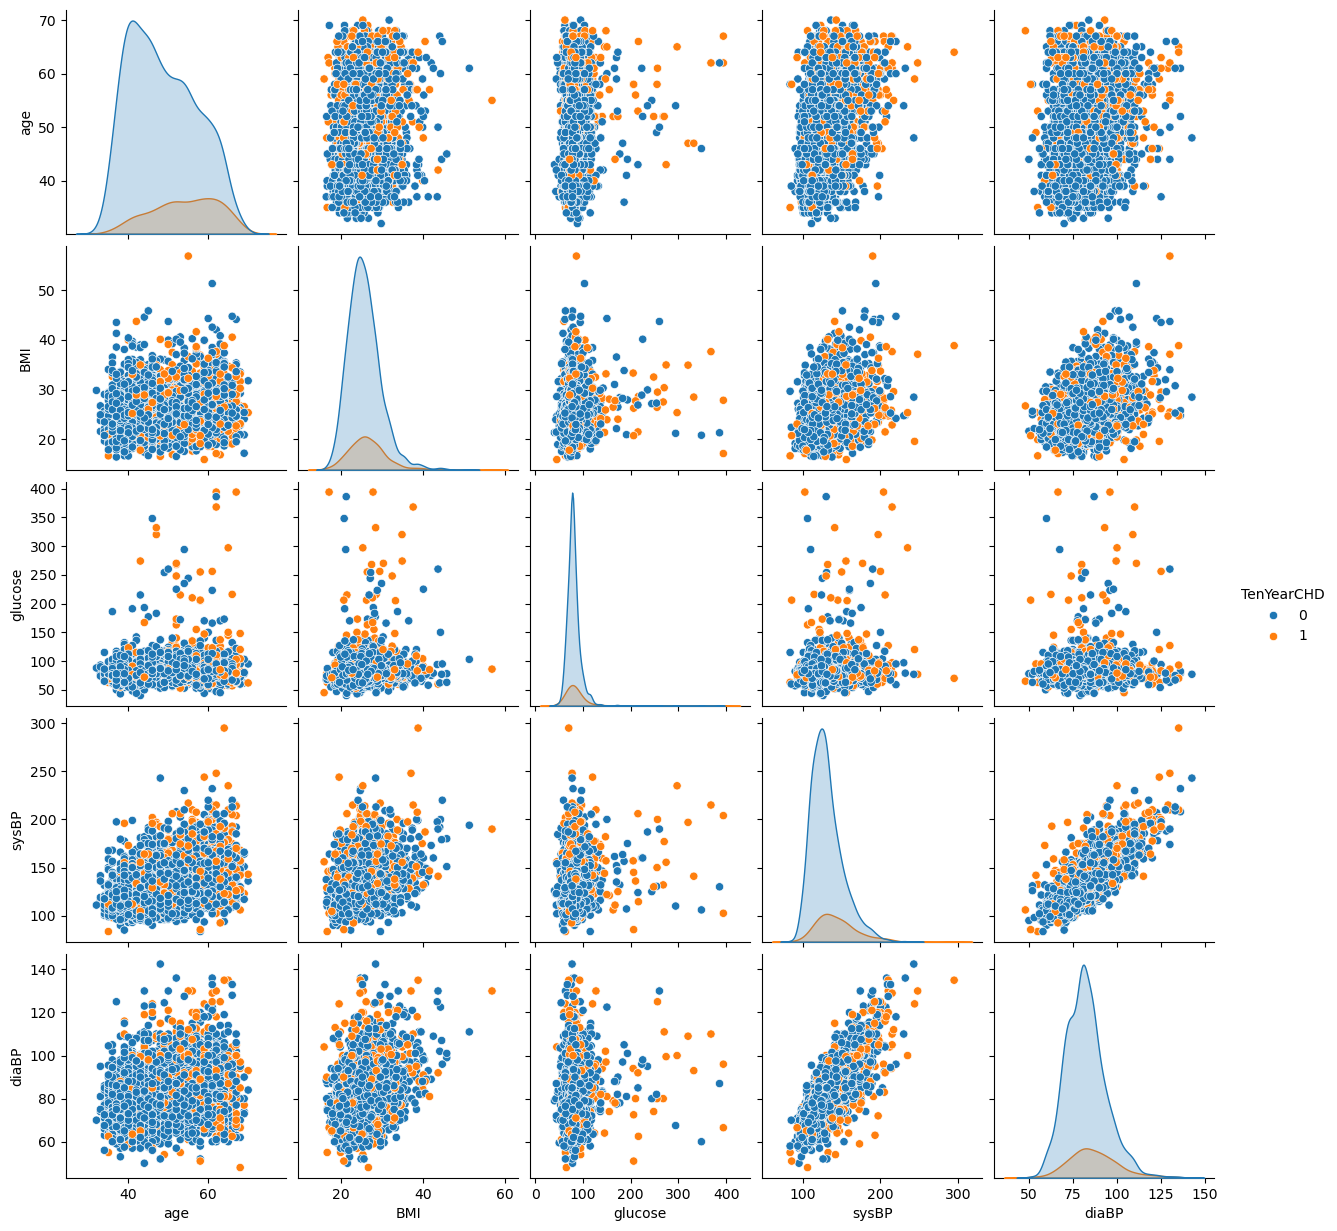

In [13]:
sns.pairplot(df[['age', 'BMI', 'glucose', 'sysBP', 'diaBP', 'TenYearCHD']], hue='TenYearCHD')

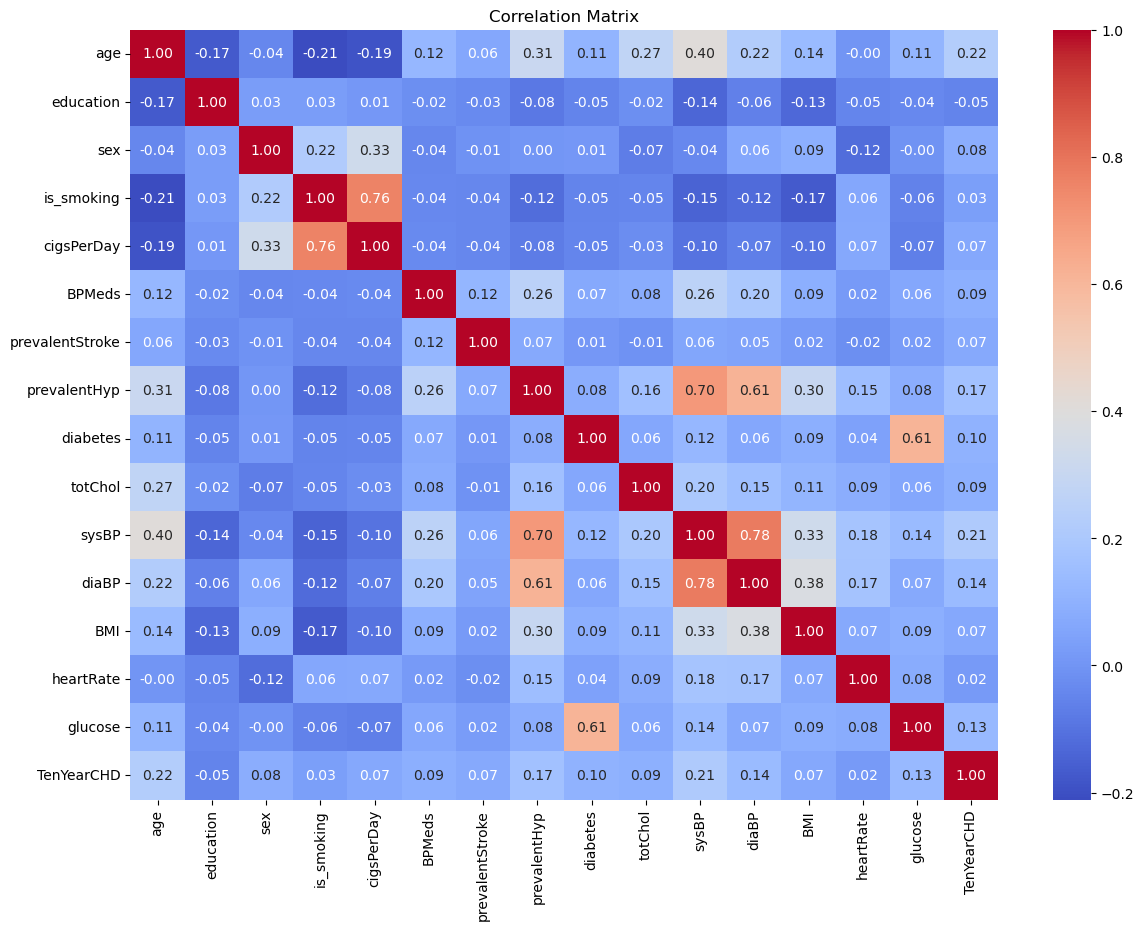

In [14]:
# Correlation analysis
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 6. Outlier Treatment

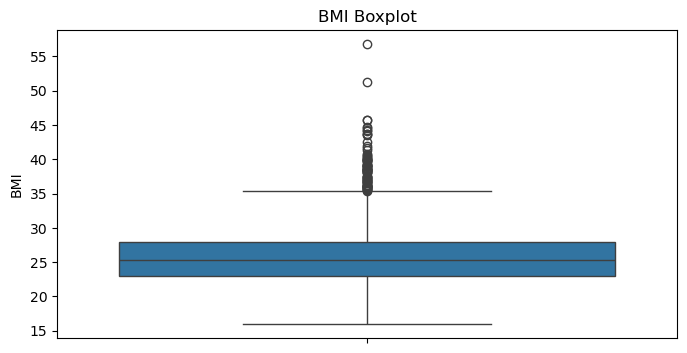

In [15]:
# Boxplot for BMI
plt.figure(figsize=(8,4))
sns.boxplot(df['BMI'])
plt.title('BMI Boxplot')
plt.show()

In [16]:
# Cap outliers for BMI at 99th percentile
bmi_99 = df['BMI'].quantile(0.99)
df['BMI'] = np.where(df['BMI'] > bmi_99, bmi_99, df['BMI'])

### 7. Check Distributions & Transformations

In [17]:
# Skewness
for col in ['totChol', 'sysBP', 'diaBP', 'glucose']:
    print(f"{col} Skewness: {df[col].skew():.2f}")

totChol Skewness: 0.95
sysBP Skewness: 1.18
diaBP Skewness: 0.72
glucose Skewness: 6.46


In [18]:
# Log-transform skewed columns
for col in ['totChol', 'glucose']:
    df[col] = np.log1p(df[col])

### 8. Feature Engineering

In [19]:
if df['education'].dtype != np.number:
    df = pd.get_dummies(df, columns=['education'], drop_first=True)

C:\Users\Bhusan\AppData\Local\Temp\ipykernel_19076\2075835535.py:1: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df['education'].dtype != np.number:


### 9. Split Data into Train/Test Sets

In [20]:
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 10. Feature Scaling

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 11. Model Training and Evaluation Functions

In [22]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [23]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")


Logistic Regression Results:
Accuracy: 0.8539823008849557
Precision: 0.6666666666666666
Recall: 0.058823529411764705
F1 Score: 0.10810810810810811
Confusion Matrix:
 [[573   3]
 [ 96   6]]


In [24]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
evaluate_model(dt, X_train, y_train, X_test, y_test, "Decision Tree")


Decision Tree Results:
Accuracy: 0.7713864306784661
Precision: 0.2523364485981308
Recall: 0.2647058823529412
F1 Score: 0.2583732057416268
Confusion Matrix:
 [[496  80]
 [ 75  27]]


In [25]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest")


Random Forest Results:
Accuracy: 0.8539823008849557
Precision: 0.7142857142857143
Recall: 0.049019607843137254
F1 Score: 0.09174311926605505
Confusion Matrix:
 [[574   2]
 [ 97   5]]


In [26]:
# Support Vector Machine
svc = SVC()
evaluate_model(svc, X_train_scaled, y_train, X_test_scaled, y_test, "Support Vector Machine")


Support Vector Machine Results:
Accuracy: 0.8480825958702065
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[575   1]
 [102   0]]


In [27]:
# K Nearest Neighbors
knn = KNeighborsClassifier()
evaluate_model(knn, X_train_scaled, y_train, X_test_scaled, y_test, "K Nearest Neighbors")


K Nearest Neighbors Results:
Accuracy: 0.8392330383480826
Precision: 0.3157894736842105
Recall: 0.058823529411764705
F1 Score: 0.09917355371900827
Confusion Matrix:
 [[563  13]
 [ 96   6]]


### 12. Cross Validation

In [28]:
models = [
    ('Logistic Regression', lr),
    ('Decision Tree', dt),
    ('Random Forest', rf),
    ('Support Vector Machine', svc),
    ('K Nearest Neighbors', knn)
]

print("\nCross Validation Scores (Accuracy, 5-fold):")
for name, model in models:
    if name in ['Logistic Regression', 'Support Vector Machine', 'K Nearest Neighbors']:
        scores = cross_val_score(model, scaler.transform(X), y, cv=5, scoring='accuracy')
    else:
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean()*100}")


Cross Validation Scores (Accuracy, 5-fold):
Logistic Regression: 85.66371681415929
Decision Tree: 76.19469026548673
Random Forest: 85.07374631268435
Support Vector Machine: 84.86725663716813
K Nearest Neighbors: 83.77581120943954


### 13. Conclusion
-Based on 5-fold cross-validation, Logistic Regression achieved the highest accuracy score of 85.66%, closely followed by Random Forest at 85.07%. These models demonstrated superior performance compared to Decision Tree, SVM, and KNN
